# Section 3

In [15]:
# Import required packages
from IPython.display import clear_output
import random
from tqdm import tqdm
import joblib
import uuid 
import subprocess
import json
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import KFold
from sklearn.linear_model import ElasticNet, ARDRegression
import dynamo as dyn
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
import seaborn as sns
from upsetplot import from_contents
from upsetplot import plot
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import fisher_exact
histone_palette = { #Define a standard color for each histone mark
    'H3K27ac':sns.color_palette('colorblind')[0],
    'H3K9ac':sns.color_palette('colorblind')[1],
    'H3K4me3':sns.color_palette('colorblind')[2],
    'H3K4me1':sns.color_palette('colorblind')[3],
    'H3K9me3':sns.color_palette('colorblind')[4],
    'H3K27me3':sns.color_palette('colorblind')[5],
    'H3K36me3':sns.color_palette('colorblind')[6],
}
dyn.configuration.set_pub_style() # Define publication style quality for figures

In [2]:
# Load data
adata_genes = sc.read_h5ad('../results/adata_genes.h5ad')

In [5]:
# Define function to calculate the weight of each gene for each histone mark model
def get_gene_weights(histone, adata, protein_coding=False):

    feature_selector_path = '../results/models/' + histone + '_feature_selector.pkl'
    feature_selector = joblib.load(feature_selector_path)

    dim_reduction_path = '../results/models/' + histone + '_dim_reduction.pkl'
    dim_reduction = joblib.load(dim_reduction_path)

    model_path = '../results/models/' + histone + '_model.pkl'
    model = joblib.load(model_path)

    used_genes = np.array(adata.var_names)[feature_selector.coef_ != 0]
    gene_weights = dim_reduction.inverse_transform(model.coef_.reshape(1,-1))

    gene_weights_df = pd.DataFrame(np.concatenate([gene_weights, np.abs(gene_weights)]).T, index=used_genes, columns=['gene_weight', 'gene_weight_abs'])
    gene_df = pd.concat([adata.var, gene_weights_df], join='inner', axis=1).sort_values(by='gene_weight_abs', ascending=False)
    
    gene_df[gene_df == 'nan'] = np.nan
    
    if protein_coding:
        gene_df = gene_df[gene_df.gene_biotype == 'protein_coding']
    
    return gene_df

In [14]:
# Define function to do GSEA for the genes selected for each model
def get_panther_overrepresentation_df(histone, adata, top_n=20):
    
    genes = get_gene_weights(histone, adata).dropna(axis=0, subset=['gene_name']).index.tolist()
    gene_string = ','.join(genes)
    panther_db_url = "http://pantherdb.org/services/oai/pantherdb/enrich/overrep?geneInputList=" + gene_string + "&organism=9606&annotDataSet=GO%3A0008150&enrichmentTestType=FISHER&correction=FDR"

    subprocess.call("curl \"" + panther_db_url + "\" -H \"accept: application/json\" --output ../results/enrichment/" + histone + "_panther.json", shell=True)
    
    clear_output()
    
    with open('../results/enrichment/' + histone + '_panther.json', 'r') as f:
        panther_json = json.load(f)
        
    go_terms = []
    negative_log_p_values = []
    fold_enrichments = []
    for go_result in panther_json['results']['result']:
        try:
            go_term = go_result['term']['label'] + ' (' + go_result['term']['id'] + ')'
            negative_log_p_value = -np.log(go_result['pValue'])
            fold_enrichment = go_result['fold_enrichment']
        except:
            continue

        go_terms += [go_term]
        negative_log_p_values += [negative_log_p_value]
        fold_enrichments += [fold_enrichment]

    enrichment_df = pd.DataFrame(np.array([go_terms, negative_log_p_values, fold_enrichments]).T, columns=['go_term', 'negative_log_p_value', 'fold_enrichment'])
    enrichment_df['negative_log_p_value'] = enrichment_df['negative_log_p_value'].astype(float)
    enrichment_df['fold_enrichment'] = enrichment_df['fold_enrichment'].astype(float)
    
    return enrichment_df.iloc[0:top_n]

## Figure 3

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator ElasticNet from version 1.0.1 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TruncatedSVD from version 1.0.1 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator ARDRegression from version 1.0.1 when using version 1.1.3. This mi

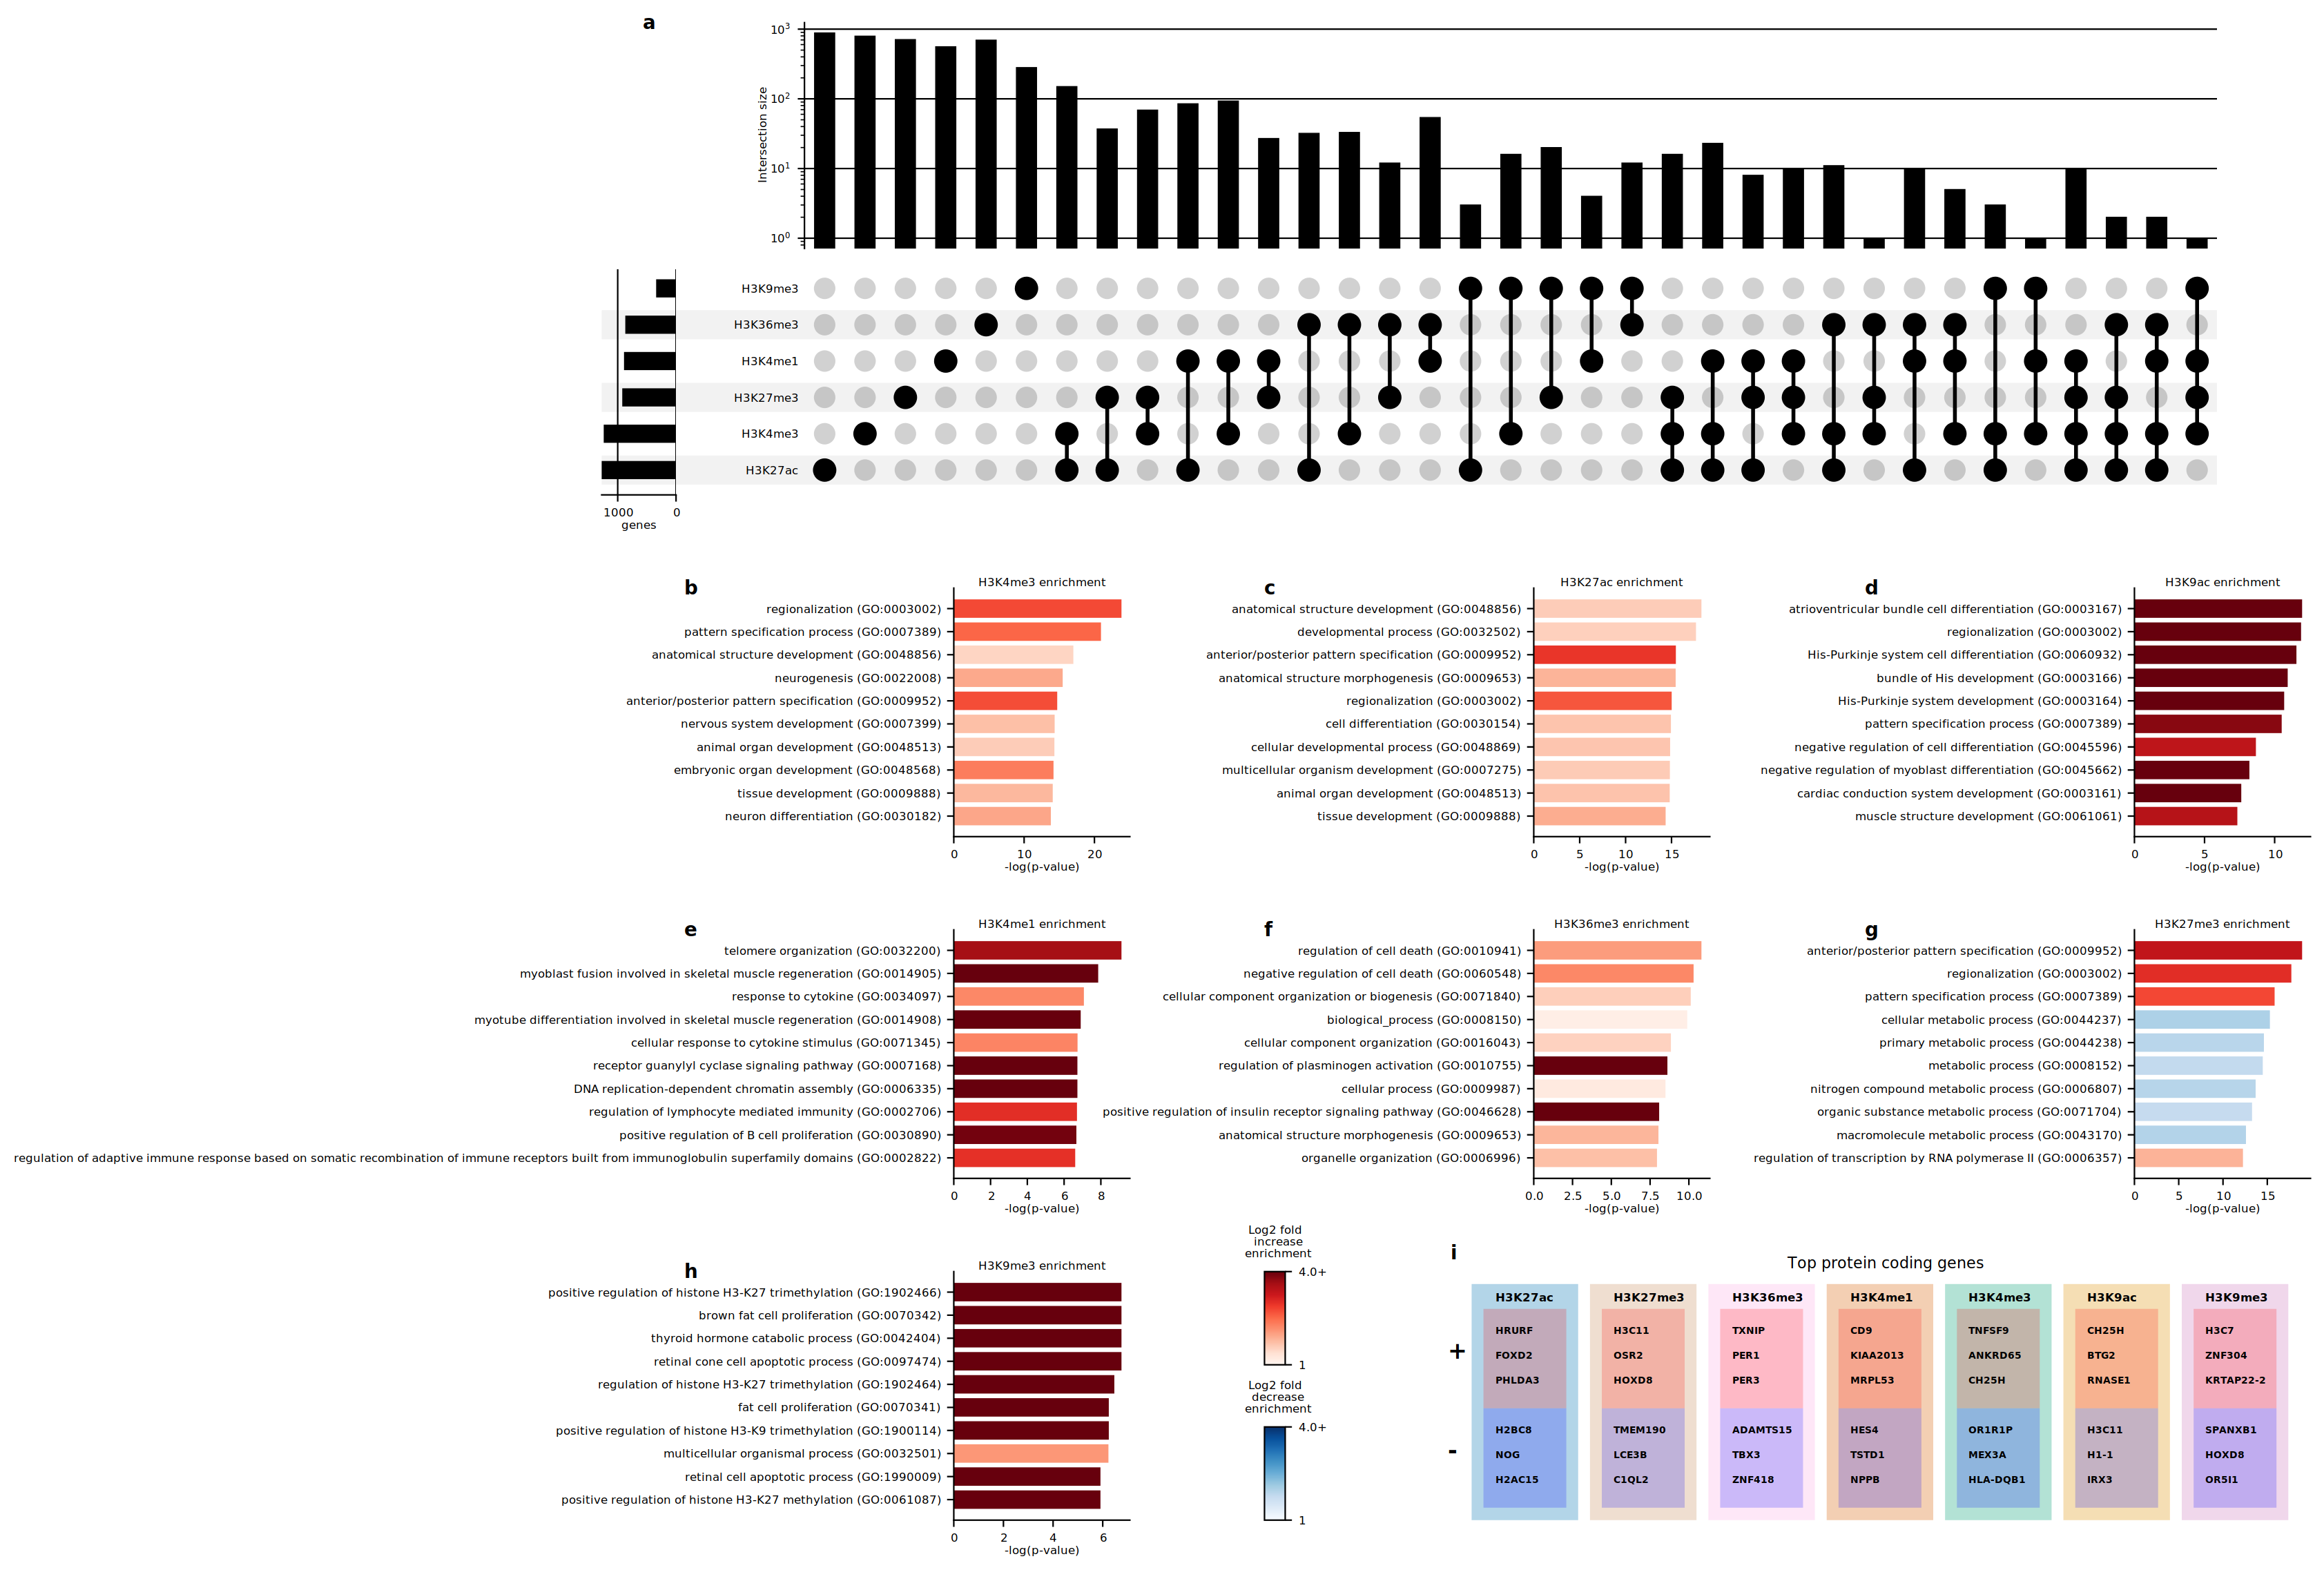

In [22]:
# Setting the number of rows and columns
nrows = 3
ncols = 10

# Determining figure dimensions based on nrows and ncols
fig_height = nrows * 1.5
fig_width = ncols * 1.5

# Initializing a new figure
fig = plt.figure(figsize=(fig_width, fig_height))

# Retrieving gene weights for various markers
contents = {'H3K4me3': get_gene_weights('H3K4me3', adata_genes).index.tolist(),
            'H3K27me3': get_gene_weights('H3K27me3', adata_genes).index.tolist(),
            'H3K36me3': get_gene_weights('H3K36me3', adata_genes).index.tolist(),
            'H3K9me3': get_gene_weights('H3K9me3', adata_genes).index.tolist(),
            'H3K27ac': get_gene_weights('H3K27ac', adata_genes).index.tolist(),
            'H3K4me1': get_gene_weights('H3K4me1', adata_genes).index.tolist()}
contents = from_contents(contents)

# Plotting the contents
plot(contents, fig=fig) 

# Modifying axes properties
fig.axes[2].set_xlabel('genes')
fig.axes[3].set_yscale('log')

# Grid specification for placement of elements
gs = GridSpec(nrows=5, ncols=7)

ax = fig.add_axes(rect=[0.35, -0.4, 0.085, 0.4])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
enrichment_df = get_panther_overrepresentation_df('H3K4me3', adata_genes, top_n=10)
y_pos = np.arange(10)
cmap_red = mpl.cm.get_cmap('Reds')
cmap_blue = mpl.cm.get_cmap('Blues')
colors = [cmap_red(np.log2(fold)/np.log2(16)) if fold>1 else cmap_blue(np.log2(1/(fold+0.0001))/np.log2(16)) for fold in enrichment_df['fold_enrichment'].tolist()]
ax.barh(y_pos, enrichment_df['negative_log_p_value'], color=colors, align='center') #xerr=error
ax.set_yticks(y_pos, labels=enrichment_df['go_term'])
ax.set_xlabel('-log(p-value)')
ax.set_title('H3K4me3 enrichment')
ax.invert_yaxis()  # labels read top-to-bottom

ax = fig.add_axes(rect=[0.63, -0.4, 0.085, 0.4])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
enrichment_df = get_panther_overrepresentation_df('H3K27ac', adata_genes, top_n=10)
y_pos = np.arange(10)
cmap_red = mpl.cm.get_cmap('Reds')
cmap_blue = mpl.cm.get_cmap('Blues')
colors = [cmap_red(np.log2(fold)/np.log2(16)) if fold>1 else cmap_blue(np.log2(1/(fold+0.0001))/np.log2(16)) for fold in enrichment_df['fold_enrichment'].tolist()]
ax.barh(y_pos, enrichment_df['negative_log_p_value'], color=colors, align='center') #xerr=error
ax.set_yticks(y_pos, labels=enrichment_df['go_term'])
ax.set_xlabel('-log(p-value)')
ax.set_title('H3K27ac enrichment')
ax.invert_yaxis()  # labels read top-to-bottom

ax = fig.add_axes(rect=[0.92, -0.4, 0.085, 0.4])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
enrichment_df = get_panther_overrepresentation_df('H3K9ac', adata_genes, top_n=10)
y_pos = np.arange(10)
cmap_red = mpl.cm.get_cmap('Reds')
cmap_blue = mpl.cm.get_cmap('Blues')
colors = [cmap_red(np.log2(fold)/np.log2(16)) if fold>1 else cmap_blue(np.log2(1/(fold+0.0001))/np.log2(16)) for fold in enrichment_df['fold_enrichment'].tolist()]
ax.barh(y_pos, enrichment_df['negative_log_p_value'], color=colors, align='center') #xerr=error
ax.set_yticks(y_pos, labels=enrichment_df['go_term'])
ax.set_xlabel('-log(p-value)')
ax.set_title('H3K9ac enrichment')
ax.invert_yaxis()  # labels read top-to-bottom

ax = fig.add_axes(rect=[0.35, -0.95, 0.085, 0.4])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
enrichment_df = get_panther_overrepresentation_df('H3K4me1', adata_genes, top_n=10)
y_pos = np.arange(10)
cmap_red = mpl.cm.get_cmap('Reds')
cmap_blue = mpl.cm.get_cmap('Blues')
colors = [cmap_red(np.log2(fold)/np.log2(16)) if fold>1 else cmap_blue(np.log2(1/(fold+0.0001))/np.log2(16)) for fold in enrichment_df['fold_enrichment'].tolist()]
ax.barh(y_pos, enrichment_df['negative_log_p_value'], color=colors, align='center') #xerr=error
ax.set_yticks(y_pos, labels=enrichment_df['go_term'])
ax.set_xlabel('-log(p-value)')
ax.set_title('H3K4me1 enrichment')
ax.invert_yaxis()  # labels read top-to-bottom

ax = fig.add_axes(rect=[0.63, -0.95, 0.085, 0.4])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
enrichment_df = get_panther_overrepresentation_df('H3K36me3', adata_genes, top_n=10)
y_pos = np.arange(10)
cmap_red = mpl.cm.get_cmap('Reds')
cmap_blue = mpl.cm.get_cmap('Blues')
colors = [cmap_red(np.log2(fold)/np.log2(16)) if fold>1 else cmap_blue(np.log2(1/(fold+0.0001))/np.log2(16)) for fold in enrichment_df['fold_enrichment'].tolist()]
ax.barh(y_pos, enrichment_df['negative_log_p_value'], color=colors, align='center') #xerr=error
ax.set_yticks(y_pos, labels=enrichment_df['go_term'])
ax.set_xlabel('-log(p-value)')
ax.set_title('H3K36me3 enrichment')
ax.invert_yaxis()  # labels read top-to-bottom

ax = fig.add_axes(rect=[0.92, -0.95, 0.085, 0.4])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
enrichment_df = get_panther_overrepresentation_df('H3K27me3', adata_genes, top_n=10)
y_pos = np.arange(10)
cmap_red = mpl.cm.get_cmap('Reds')
cmap_blue = mpl.cm.get_cmap('Blues')
colors = [cmap_red(np.log2(fold)/np.log2(16)) if fold>1 else cmap_blue(np.log2(1/(fold+0.0001))/np.log2(16)) for fold in enrichment_df['fold_enrichment'].tolist()]
ax.barh(y_pos, enrichment_df['negative_log_p_value'], color=colors, align='center') #xerr=error
ax.set_yticks(y_pos, labels=enrichment_df['go_term'])
ax.set_xlabel('-log(p-value)')
ax.set_title('H3K27me3 enrichment')
ax.invert_yaxis()  # labels read top-to-bottom

ax = fig.add_axes(rect=[0.35, -1.5, 0.085, 0.4])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
enrichment_df = get_panther_overrepresentation_df('H3K9me3', adata_genes, top_n=10)
y_pos = np.arange(10)
cmap_red = mpl.cm.get_cmap('Reds')
cmap_blue = mpl.cm.get_cmap('Blues')
colors = [cmap_red(np.log2(fold)/np.log2(16)) if fold>1 else cmap_blue(np.log2(1/(fold+0.0001))/np.log2(16)) for fold in enrichment_df['fold_enrichment'].tolist()]
ax.barh(y_pos, enrichment_df['negative_log_p_value'], color=colors, align='center') #xerr=error
ax.set_yticks(y_pos, labels=enrichment_df['go_term'])
ax.set_xlabel('-log(p-value)')
ax.set_title('H3K9me3 enrichment')
ax.invert_yaxis()  # labels read top-to-bottom

ax_color = fig.add_axes(rect=[0.5, -1.25, 0.01, 0.15])
ax_color.set_title('Log2 fold \n increase \n enrichment \n')
mpl.colorbar.ColorbarBase(ax=ax_color, cmap=cmap_red, orientation="vertical")
ax_color.set_yticks([0,1], labels=[1, str(round(np.log2(16),1)) + '+'])

ax_color = fig.add_axes(rect=[0.5, -1.5, 0.01, 0.15])
ax_color.set_title('Log2 fold \n decrease \n enrichment \n')
mpl.colorbar.ColorbarBase(ax=ax_color, cmap=cmap_blue, orientation="vertical")
ax_color.set_yticks([0,1], labels=[1, str(round(np.log2(16),1)) + '+'])

ax = fig.add_axes(rect=[0.6, -1.5, 0.4, 0.4])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axis('off')

for i, histone in enumerate(np.unique(adata_genes.obs.histone)):
    rect=mpatches.Rectangle((i,0.0),0.9,0.95, 
                            fill=True,
                            color=histone_palette[histone],
                            alpha=0.3,
                            linewidth=0)
    ax.add_patch(rect)
    rect=mpatches.Rectangle((i+0.1,0.45),0.7,0.4, 
                            fill=True,
                            color='red',
                            alpha=0.2,
                            linewidth=0)
    upregulated = get_gene_weights(histone, adata_genes, protein_coding=True).sort_values(by='gene_weight', ascending=False).symbol.dropna()[0:3].tolist()
    ax.text(i+0.2, 0.75, upregulated[0], size=5, weight="bold")
    ax.text(i+0.2, 0.65, upregulated[1], size=5, weight="bold")
    ax.text(i+0.2, 0.55, upregulated[2], size=5, weight="bold")
    ax.add_patch(rect)
    rect=mpatches.Rectangle((i+0.1,0.05),0.7,0.4, 
                            fill=True,
                            color='blue',
                            alpha=0.2,
                            linewidth=0)
    ax.add_patch(rect)
    downregulated = get_gene_weights(histone, adata_genes, protein_coding=True).sort_values(by='gene_weight', ascending=True).symbol.dropna()[0:3].tolist()
    ax.text(i+0.2, 0.35, downregulated[0], size=5, weight="bold")
    ax.text(i+0.2, 0.25, downregulated[1], size=5, weight="bold")
    ax.text(i+0.2, 0.15, downregulated[2], size=5, weight="bold")
    ax.text(i+0.2, 0.88, histone, size=6, weight="bold")
ax.text(-0.2, 0.65, '+', size=12, weight="bold")
ax.text(-0.2, 0.25, '-', size=12, weight="bold")
ax.set_xlim(0,7)
ax.set_ylim(0,1)
ax.set_title('Top protein coding genes', size=8)

# Setting figure size
fig.set_size_inches(fig_width, fig_height)

# Adding annotations to the figure
fig.text(0.2, 0.9, 'a', size=10, weight="bold")
fig.text(0.22, -0.01, 'b', size=10, weight="bold")
fig.text(0.5, -0.01, 'c', size=10, weight="bold")
fig.text(0.79, -0.01, 'd', size=10, weight="bold")
fig.text(0.22, -0.56, 'e', size=10, weight="bold")
fig.text(0.5, -0.56, 'f', size=10, weight="bold")
fig.text(0.79, -0.56, 'g', size=10, weight="bold")
fig.text(0.22, -1.11, 'h', size=10, weight="bold")
fig.text(0.59, -1.08, 'i', size=10, weight="bold")

# Saving the figure as a PDF file
fig.savefig("../figures/figure3.pdf", bbox_inches='tight')

# Returning the figure object
fig

## Supplementary Figure 3

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator ElasticNet from version 1.0.1 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TruncatedSVD from version 1.0.1 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator ARDRegression from version 1.0.1 when using version 1.1.3. This mi

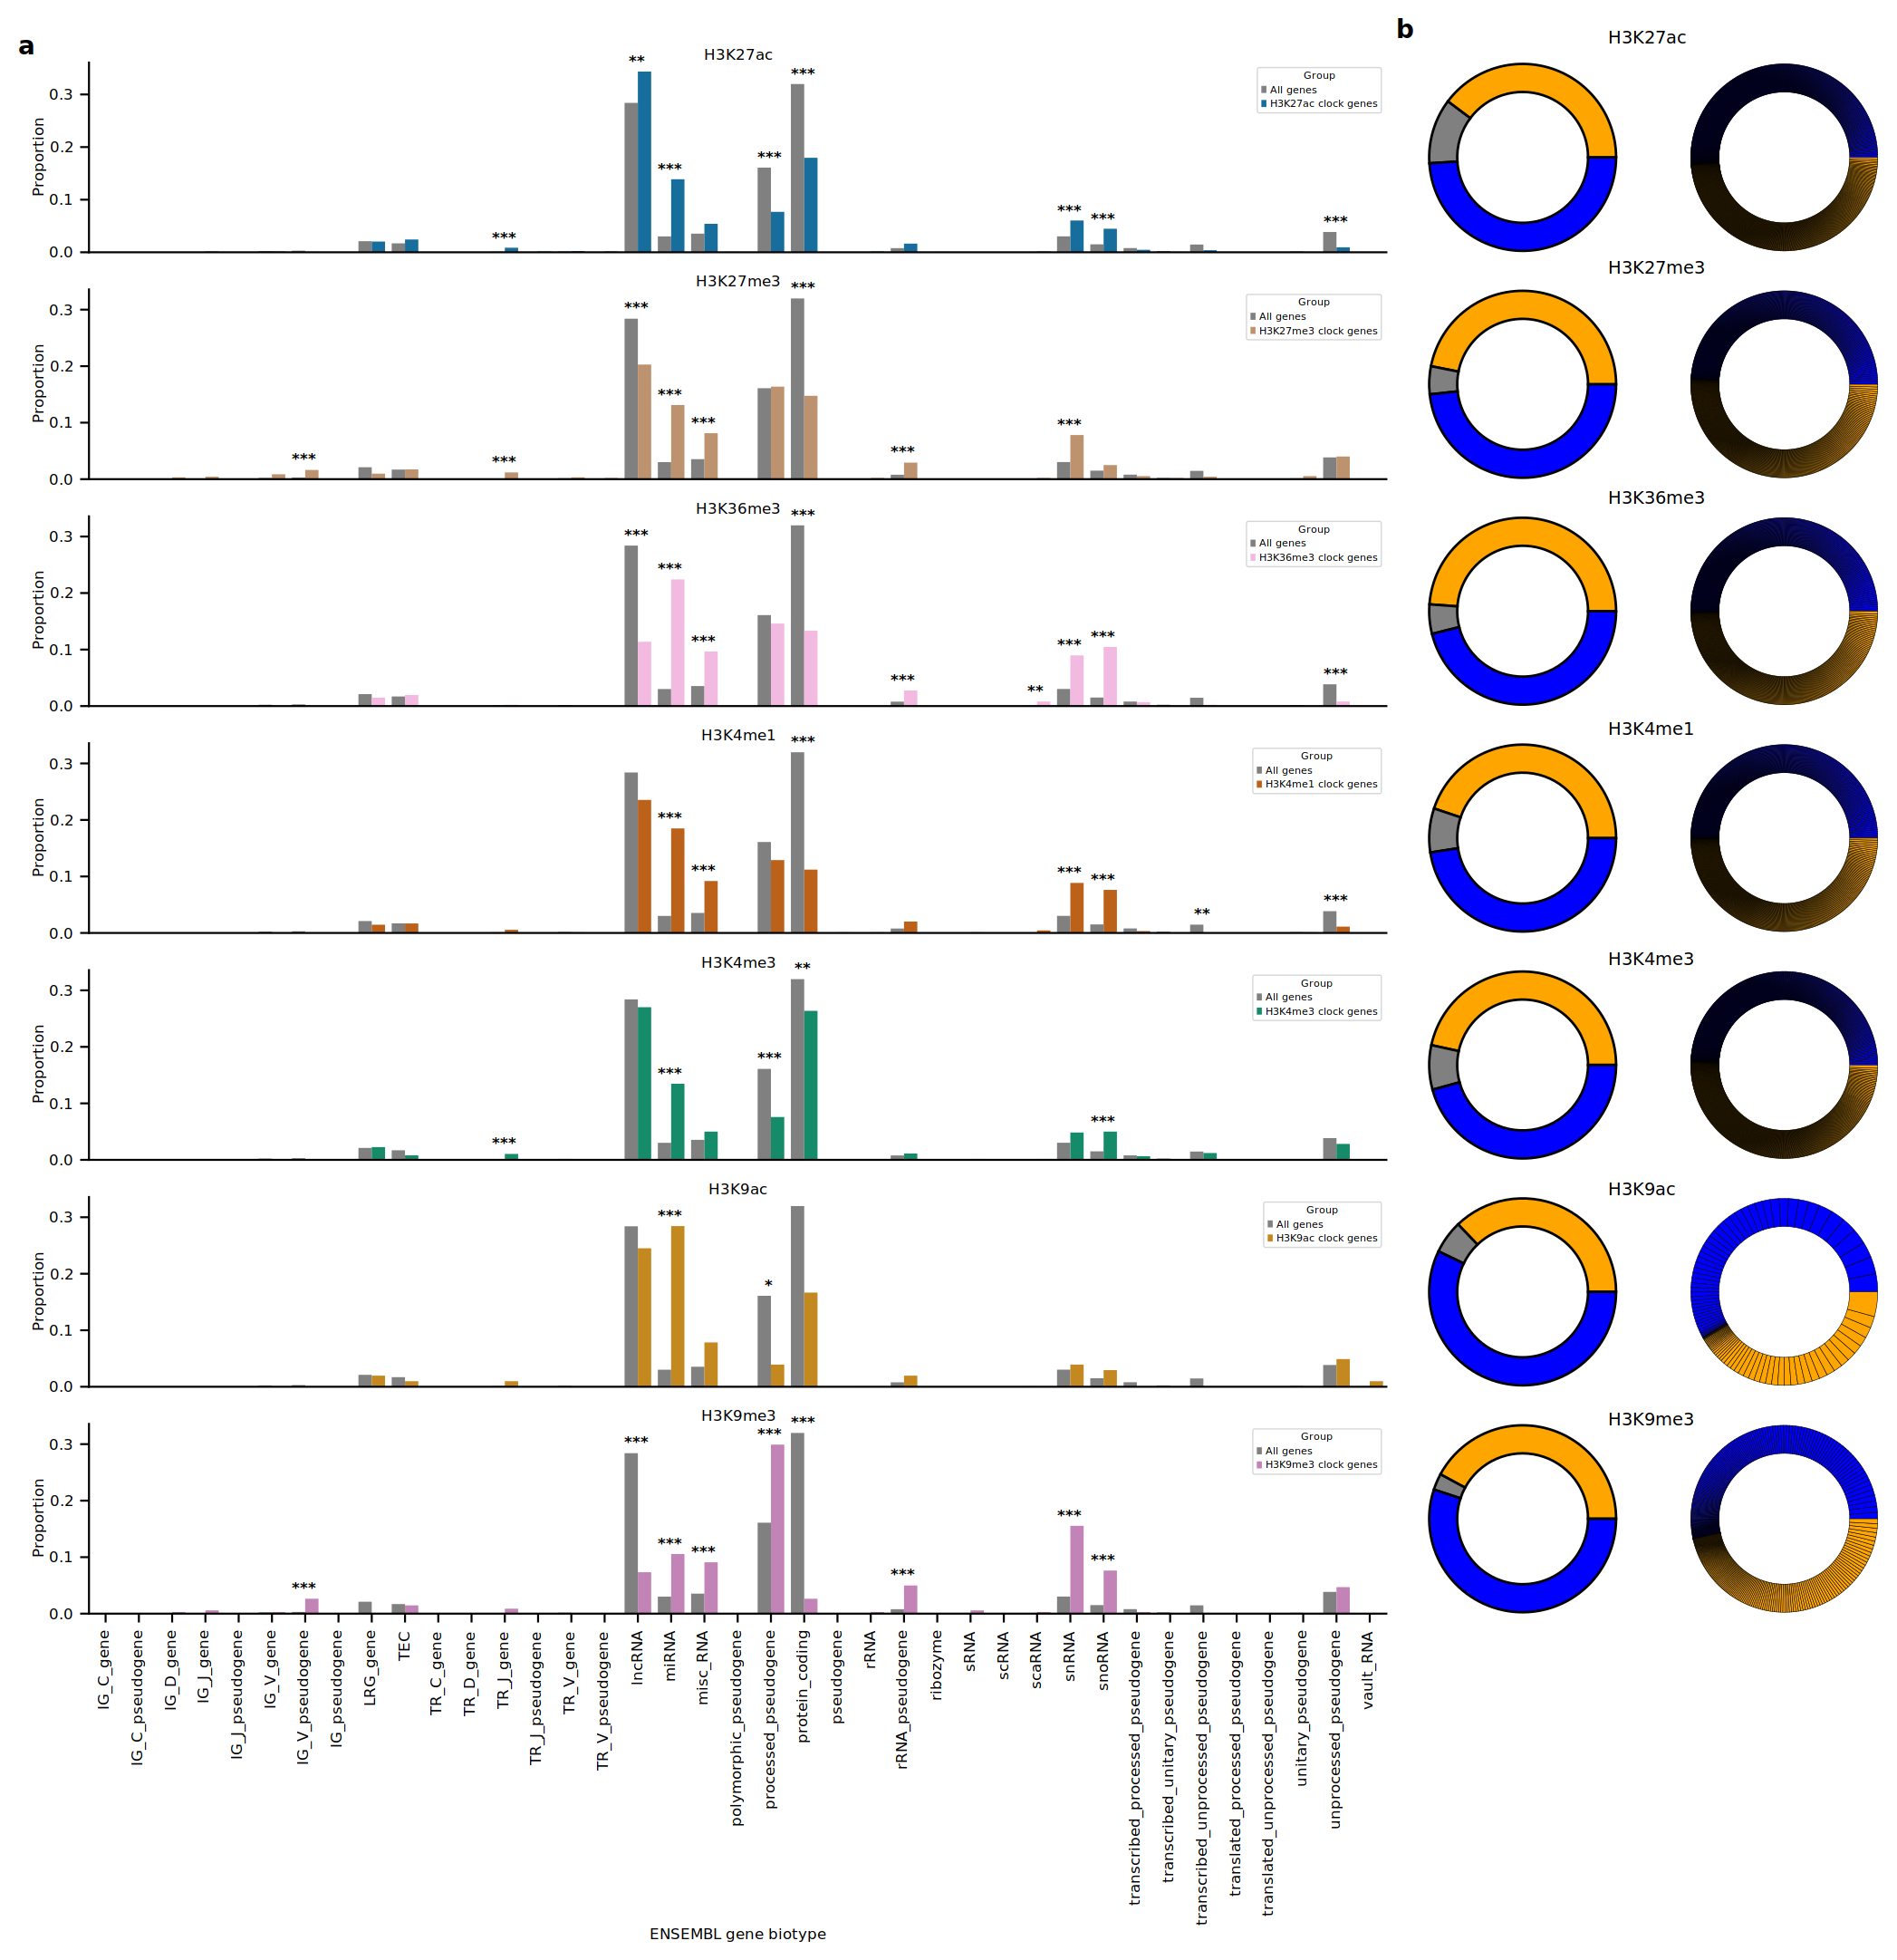

In [21]:
# Setting up the number of rows and columns
nrows = 7
ncols = 7

# Calculating the figure height and width
fig_height = nrows * 1.5
fig_width = ncols * 1.5

# Creating a figure object
fig = plt.figure(figsize=(fig_width, fig_height))
gs = GridSpec(nrows=nrows, ncols=ncols)

# Adding text to the figure
fig.text(0, (nrows-0)/nrows - 0.01, 'a', size=10, weight="bold")
fig.text(5/7 + 0.01, (nrows-0.01)/nrows, 'b', size=10, weight="bold")

# Calculating control data frame
control_df = adata_genes.var.groupby(by='gene_biotype').count()/adata_genes.var.shape[0]
control_df = control_df.iloc[:,0].reset_index()
control_df.columns = ['gene_biotype', 'percent']
control_df['Group'] = 'All genes'

# Looping through unique histones and plotting
for i, histone in enumerate(np.unique(adata_genes.obs.histone)):
    ax = fig.add_subplot(gs[i, 0:5])
    ax.set_title(histone)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Calculating histone data frame
    histone_df = get_gene_weights(histone, adata_genes).groupby(by='gene_biotype').count()/get_gene_weights(histone, adata_genes).shape[0]
    histone_df = histone_df.iloc[:,0].reset_index()
    histone_df.columns = ['gene_biotype', 'percent']
    histone_df['Group'] = histone + ' clock genes'
    
    # Plotting the data
    plot_df = pd.concat([control_df, histone_df])
    sns.barplot(data=plot_df, x="gene_biotype", y="percent", hue='Group', palette=['gray', histone_palette[histone]], ax=ax)
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylabel('Proportion')
    if i != 6:
        ax.set_xticks([])
        ax.set_xlabel('')
    else:
        ax.set_xlabel('ENSEMBL gene biotype')
        
    # Running Fisher's exact test and annotating the plot
    for gene_biotype in np.unique(adata_genes.var.gene_biotype):
            
        a = np.sum(adata_genes.var.gene_biotype == gene_biotype)
        b = np.sum(adata_genes.var.gene_biotype != gene_biotype)
        c = np.sum(get_gene_weights(histone, adata_genes).gene_biotype == gene_biotype)
        d = np.sum(get_gene_weights(histone, adata_genes).gene_biotype != gene_biotype)
        fisher_exact_test_df = pd.DataFrame([[a, b],[c, d]], columns=['gene_biotype_of_interest', 'other'], index=['all_genes', 'histone'])
        
        p_value = fisher_exact(fisher_exact_test_df)[1]
        
        gene_biotype_index = np.where(np.unique(adata_genes.var.gene_biotype) == gene_biotype)[0][0]
        x_pos = ax.containers[0][gene_biotype_index].get_xy()[0]
        if np.mean(adata_genes.var.gene_biotype == gene_biotype) > np.mean(get_gene_weights(histone, adata_genes).gene_biotype == gene_biotype):
            y_pos = np.mean(adata_genes.var.gene_biotype == gene_biotype)
        else:
            y_pos = np.mean(get_gene_weights(histone, adata_genes).gene_biotype == gene_biotype)
            
        if p_value < 0.0001/len(np.unique(adata_genes.var.gene_biotype)): #p-value with Bonferroni correction for multiple tests
            ax.text(x_pos, y_pos+0.01, '***', size=6, weight="bold")
        elif p_value < 0.001/len(np.unique(adata_genes.var.gene_biotype)):
            ax.text(x_pos+0.12, y_pos+0.01, '**', size=6, weight="bold")
        elif p_value < 0.01/len(np.unique(adata_genes.var.gene_biotype)):
            ax.text(x_pos+0.22, y_pos+0.01, '*', size=6, weight="bold")
            
# Looping through unique histones and creating polar plots
for i, histone in enumerate(np.unique(adata_genes.obs.histone)):
    
    ax = fig.add_subplot(gs[i, 5], polar=True)
    
    size = 0.3
    
    model_path = '../results/models/' + histone + '_model.pkl'
    model = joblib.load(model_path)
    vals = np.sort(model.coef_)
    vals = np.array([np.sum(vals > 0), np.sum(vals == 0), np.sum(vals < 0)]).reshape(-1,1)
    colors = ['orange', 'gray', 'blue']
    vals=np.abs(vals)
    valsnorm = vals/np.sum(vals)*2*np.pi
    valsleft = np.cumsum(np.append(0, valsnorm.flatten()[:-1])).reshape(vals.shape)

    ax.bar(x=valsleft[:, 0],
           width=valsnorm.sum(axis=1), bottom=1-size, height=size,
           color=colors, edgecolor='black', linewidth=1, align="edge")

    ax.set_axis_off()
    
    ax = fig.add_subplot(gs[i, 6], polar=True)
    
    size = 0.3
    
    vals = np.array(get_gene_weights(histone, adata_genes, False).sort_values(by='gene_weight').gene_weight.tolist()).reshape(-1,1)
    colors = ['orange' if weight > 0 else 'gray' if weight == 0 else 'blue' for weight in vals.flatten()]
    vals=np.abs(vals)
    valsnorm = vals/np.sum(vals)*2*np.pi
    valsleft = np.cumsum(np.append(0, valsnorm.flatten()[:-1])).reshape(vals.shape)

    ax.bar(x=valsleft[:, 0],
           width=valsnorm.sum(axis=1), bottom=1-size, height=size,
           color=colors, edgecolor='black', linewidth=0.2, align="edge")

    ax.set_axis_off()
    
    fig.text(5.85/7, (nrows-i/1.18 -0.03)/nrows, histone, size=7)

# Adjusting layout
plt.tight_layout()
    
# Displaying the plot
plt.show()

# Saving the figure
fig.savefig("../figures/supplementary_figure3.pdf", bbox_inches='tight')

# Returning the figure object
fig

## Information for the manuscript

In [9]:
print(f'Number of unique gene biotypes is {len(np.unique(adata_genes.var.gene_biotype))}')

Number of unique gene biotypes is 39


In [15]:
contents = {'H3K4me3': len(get_gene_weights('H3K4me3', adata_genes).index.tolist()),
            'H3K27me3': len(get_gene_weights('H3K27me3', adata_genes).index.tolist()),
            'H3K36me3': len(get_gene_weights('H3K36me3', adata_genes).index.tolist()),
            'H3K9me3': len(get_gene_weights('H3K9me3', adata_genes).index.tolist()),
            'H3K27ac': len(get_gene_weights('H3K27ac', adata_genes).index.tolist()),
            'H3K4me1': len(get_gene_weights('H3K4me1', adata_genes).index.tolist())}
contents

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator ElasticNet from version 1.0.1 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TruncatedSVD from version 1.0.1 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator ARDRegression from version 1.0.1 when using version 1.1.3. This mi

{'H3K4me3': 1240,
 'H3K27me3': 922,
 'H3K36me3': 870,
 'H3K9me3': 341,
 'H3K27ac': 1275,
 'H3K4me1': 892}

In [4]:
histones = [
    'H3K27ac',
    'H3K9ac',
    'H3K4me3',
    'H3K4me1',
    'H3K9me3',
    'H3K27me3',
    'H3K36me3',
    'pan_histone',
]

for histone in histones:

    feature_selector_path = '../results/models/' + histone + '_feature_selector.pkl'
    feature_selector = joblib.load(feature_selector_path)
    p = np.sum(feature_selector.coef_ != 0)
    
    print(f'P features for {histone}: {p}')

P features for H3K27ac: 1275
P features for H3K9ac: 102
P features for H3K4me3: 1240
P features for H3K4me1: 892
P features for H3K9me3: 341
P features for H3K27me3: 922
P features for H3K36me3: 870
P features for pan_histone: 3739


In [17]:
# Define function to do GSEA for the genes selected for each model
def get_overrepresentation_df(histone, adata):
    
    genes = get_gene_weights(histone, adata).dropna(axis=0, subset=['gene_name']).index.tolist()
    
    with open('../results/enrichment/' + histone + '_panther.json', 'r') as f:
        panther_json = json.load(f)
        
    go_terms = []
    negative_log_p_values = []
    fold_enrichments = []
    for go_result in panther_json['results']['result']:
        try:
            go_term = go_result['term']['label'] + ' (' + go_result['term']['id'] + ')'
            negative_log_p_value = -np.log(go_result['pValue'])
            fold_enrichment = go_result['fold_enrichment']
        except:
            continue

        go_terms += [go_term]
        negative_log_p_values += [negative_log_p_value]
        fold_enrichments += [fold_enrichment]

    enrichment_df = pd.DataFrame(np.array([go_terms, negative_log_p_values, fold_enrichments]).T, columns=['go_term', 'negative_log_p_value', 'fold_enrichment'])
    enrichment_df['negative_log_p_value'] = enrichment_df['negative_log_p_value'].astype(float)
    enrichment_df['fold_enrichment'] = enrichment_df['fold_enrichment'].astype(float)
    
    return enrichment_df

for histone in list(np.unique(adata_genes.obs.histone)) + ['pan_histone']:
    overrep_df = get_overrepresentation_df(histone, adata_genes)
    overrep_df.to_csv(f'../results/{histone}_overrep_df_table.csv')
    
for histone in list(np.unique(adata_genes.obs.histone)) + ['pan_histone']:
    gene_df = get_gene_weights(histone, adata_genes)
    gene_df.to_csv(f'../results/{histone}_gene_weight_df_table.csv')

In [85]:
# add Illumina Manifest to directory (https://emea.support.illumina.com/downloads/infinium_humanmethylation450_product_files.html)
# Define function to do GSEA for the genes selected for each model
def get_clock_overrepresentation_df(genes, clock):
    
    gene_string = ','.join(genes)
    panther_db_url = f"https://pantherdb.org/services/oai/pantherdb/enrich/overrep?geneInputList={gene_string}&organism=9606&annotDataSet=GO:0008150&enrichmentTestType=FISHER&correction=FDR"

    # Use subprocess to call curl and save the JSON output
    subprocess.call(f'curl "{panther_db_url}" -H "accept: application/json" --output ../results/enrichment/{clock}_panther.json', shell=True)

    clear_output()
    
    with open('../results/enrichment/' + clock + '_panther.json', 'r') as f:
        panther_json = json.load(f)
        
    go_terms = []
    negative_log_p_values = []
    fold_enrichments = []
    for go_result in panther_json['results']['result']:
        try:
            go_term = go_result['term']['label'] + ' (' + go_result['term']['id'] + ')'
            negative_log_p_value = -np.log(go_result['pValue'])
            fold_enrichment = go_result['fold_enrichment']
        except:
            continue

        go_terms += [go_term]
        negative_log_p_values += [negative_log_p_value]
        fold_enrichments += [fold_enrichment]

    enrichment_df = pd.DataFrame(np.array([go_terms, negative_log_p_values, fold_enrichments]).T, columns=['go_term', 'negative_log_p_value', 'fold_enrichment'])
    enrichment_df['negative_log_p_value'] = enrichment_df['negative_log_p_value'].astype(float)
    enrichment_df['fold_enrichment'] = enrichment_df['fold_enrichment'].astype(float)
    
    return enrichment_df

In [45]:
!pip install pyaging==0.1.6
import pyaging as pya

logger = pya.logger.Logger('test_logger')
device = 'cpu'
dir = 'pyaging_data'
indent_level = 1

illumina_manifest = pd.read_csv('humanmethylation450_15017482_v1-2.csv', skiprows=7, index_col=0)
illumina_manifest = illumina_manifest.fillna('')

/tmp/ipykernel_20670/1851541140.py:6: DtypeWarning: Columns (2,4,11,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  illumina_manifest = pd.read_csv('humanmethylation450_15017482_v1-2.csv', skiprows=7, index_col=0)


In [91]:
horvath2013_features = horvath2013.features
horvath2013_genes = np.array(illumina_manifest.loc[horvath2013_features, 'UCSC_RefGene_Name'])
horvath2013_genes = np.unique(';'.join(horvath2013_genes[horvath2013_genes!='']).split(';')).tolist()
horvath2013_enrichment = get_clock_overrepresentation_df(horvath2013_genes, clock='horvath2013')
horvath2013_enrichment.to_csv(f'../results/horvath2013_overrep_df_table.csv')

hannum = pya.pred.load_clock('Hannum', device, dir, logger, indent_level=indent_level)
hannum_genes = np.array(illumina_manifest.loc[hannum_features, 'UCSC_RefGene_Name'])
hannum_genes = np.unique(';'.join(hannum_genes[hannum_genes!='']).split(';')).tolist()
hannum_enrichment = get_clock_overrepresentation_df(hannum_genes, clock='hannum')
hannum_enrichment.to_csv(f'../results/hannum_overrep_df_table.csv')

dnamphenoage = pya.pred.load_clock('dnamphenoage', device, dir, logger, indent_level=indent_level)
dnamphenoage_genes = np.array(illumina_manifest.loc[dnamphenoage_features, 'UCSC_RefGene_Name'])
dnamphenoage_genes = np.unique(';'.join(dnamphenoage_genes[dnamphenoage_genes!='']).split(';')).tolist()
dnamphenoage_enrichment = get_clock_overrepresentation_df(dnamphenoage_genes, clock='dnamphenoage')
dnamphenoage_enrichment.to_csv(f'../results/dnamphenoage_overrep_df_table.csv')